## <font color='darkblue'>Preface</font>
<font size='3ptx'>How Anomaly Detection in credit card transactions works?</font>

> It’s Sunday morning, it’s quiet and you wake up with a big smile on your face. Today is going to be a great day! Except, your phone rings, rather “internationally”. You pick it up slowly and hear something really bizarre — “Bonjour, je suis Michele. Oops, sorry. I am Michele, your personal bank agent.”. What could possibly be so urgent for someone from Switzerland to call you at this hour? “Did you authorize a transaction for \$3,358.65 for 100 copies of Diablo 3?” Immediately, you start thinking of ways to explain why you did that to your loved one. “No, I didn’t !?”. Michele’s answer is quick and to the point — “Thank you, we’re on it”. Whew, that was close! But how did Michele knew that this transaction was suspicious? After all, you did order 10 new smartphones from that same bank account, last week — Michele didn’t call then.

<b>Annual global fraud losses reached \$21.8 billion in 2015, according to [Nilson Report](https://www.nilsonreport.com/upload/content_promo/The_Nilson_Report_10-17-2016.pdf)</b>. Probably you feel very lucky if you are a fraud. About every 12 cents per \$100 were stolen in the US during the same year. Our friend Michele might have a serious problem to solve here.

In this part of the series, we will train an [**Autoencoder Neural Network**](https://en.wikipedia.org/wiki/Autoencoder) (<font color='brown'>implemented in Keras</font>) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.

[The source code and pre-trained model are available on GitHub here.](https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras)

### <font color='darkgreen'>Agenda</font>
* <font size='3ptx'>[**Setup**](#sect1)</font>
* <font size='3ptx'>[**Loading the data**](#sect2)</font>
    * [**Explore data**](#sect2_1)
* <font size='3ptx'>[**Autoencoders**](#sect3)</font>
    * [**Reconstruction error**](#sect3_1)
    * [**Preparing the data**](#sect3_2)
    * [**Building the model**](#sect3_3)
    * [**Evaluation**](#sect3_4)
    * [**Reconstruction error without fraud**](#sect3_5)
    * [**Reconstruction error with fraud**](#sect3_6)
    * [**Precision vs Recall**](#sect3_7)
    * [**Prediction**](#sect3_8)
* <font size='3ptx'>[**Conclusion**](#sect4)
* <font size='3ptx'>[**Supplement**](#sect5)
    
<a id='sect1'></a>
## <font color='darkblue'>Setup</font>
We will be using TensorFlow 1.2 and Keras 2.0.4. Let’s begin:

In [42]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 10
LABELS = ["Normal", "Fraud"]

<a id='sect2'></a>
## <font color='darkblue'>Loading the data</font>
The dataset we’re going to use can be downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). It contains **data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions**. ([full data link](https://drive.google.com/file/d/1QG5-P3labih5l4M8yAAiaE1ofTsM1KR9/view?usp=sharing), [20% data link](https://drive.google.com/file/d/1WElXtIPlyo75eqgHgzhlLxdS-9HH69Id/view?usp=sharing))

In [2]:
df = pd.read_csv("../../datas/credit_card_fraud_data.csv")

<a id='sect2_1'></a>
### <font color='darkgreen'>Exploration</font>
Check the data size:

In [3]:
df.shape

(57355, 31)

31 columns, 2 of which are `Time` and `Amount`. The rest are output from the PCA transformation. Let’s check for missing values:

In [4]:
df.isnull().values.any()

False

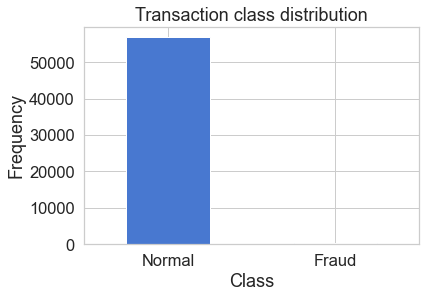

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let’s look at the two types of transactions:

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
print(f"We got {frauds.shape[0]:,d} fraud transactions; {normal.shape[0]:,d} normal transactions")

We got 492 fraud transactions; 56,863 normal transactions


How different are the amount of money used in different transaction classes?

In [7]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [8]:
normal.Amount.describe()

count    56863.000000
mean        89.307623
std        245.655345
min          0.000000
25%          5.845000
50%         22.210000
75%         77.700000
max      12910.930000
Name: Amount, dtype: float64

Let’s have a more graphical representation:

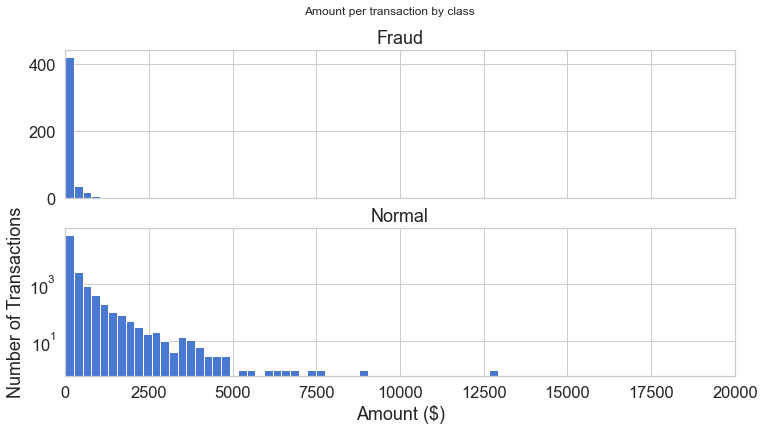

In [9]:
rcParams['figure.figsize'] = 12, 6
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

max_amount = max(normal.Amount)
bins = 50

ax1.hist(frauds.Amount, bins = bins, range=(0, max_amount))
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins, range=(0, max_amount))
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Do fraudulent transactions occur more often during certain time?

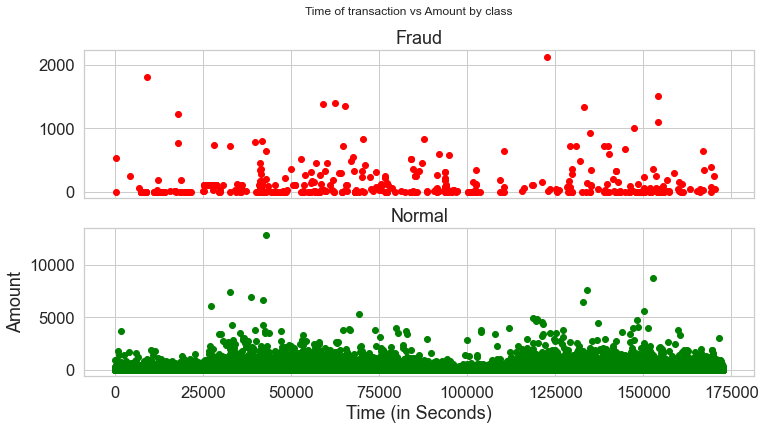

In [10]:
from IPython.display import HTML

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount, color='red')
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount, color='green')
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

Doesn’t seem like the time of transaction really matters.

<a id='sect3'></a>
## <font color='darkblue'>Autoencoders</font>
[**Autoencoders**](https://en.wikipedia.org/wiki/Autoencoder) can seem quite bizarre at first. The job of those models is to predict the input, given that same input. Puzzling? Definitely was for me, the first time I heard it. More specifically, let’s take a look at Autoencoder Neural Networks. 

This Autoencoder tries to learn to approximate the following identity function:
![autoencoder func](images/1.PNG)
<br/>

While trying to do just that might sound trivial at first, it is important to note that we <b>want to learn a compressed representation of the data</b>, thus find structure. This can be done by limiting the number of hidden units in the model. Those kind of autoencoders are called <b><font color='darkblue'>undercomplete</font></b>.

Here’s a visual representation of what an Autoencoder might learn:
![autoencoder network](images/2.PNG)
<br/>

<a id='sect3_1'></a>
### <font color='darkgreen'>Reconstruction error</font>
<b>We optimize the parameters of our Autoencoder model in such way that a special kind of error</b> — reconstruction error is minimized. In practice, the traditional squared error is often used:
![autoencoder network](images/3.PNG)
<br/>
If you want to learn more about Autoencoders I highly recommend the following videos by Hugo Larochelle:<br/>

In [11]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/FzS3tMl4Nsc?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

c:\users\johnlee\appdata\local\programs\python\python36\lib\site-packages\IPython\core\display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


<a id='sect3_2'></a>
### <font color='darkgreen'>Preparing the data</font>
First, let’s drop the `Time` column (<font color='darkblue'>not going to use it</font>) and use the scikit’s [**StandardScaler**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) on the `Amount`. The scaler removes the mean and scales the values to unit variance:

In [12]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.364533,1
1,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.787919,1
2,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.611720,1
3,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,-0.124467,1
4,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.360464,1


Training our Autoencoder is gonna be a bit different from what we are used to. Let’s say you have a dataset containing a lot of non fraudulent transactions at hand. You <b>want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only.</b> Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [43]:
RESERVED_TEST_PERT = 0.2
X_train, X_test = train_test_split(data, test_size=RESERVED_TEST_PERT, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_train = X_train.values
X_test = X_test.values
X_train.shape

(45494, 29)

In [50]:
y_test.head(10)

22600    0
52376    0
5973     0
38620    0
14283    0
7325     0
2822     0
19129    0
24688    0
45899    0
Name: Class, dtype: int64

<a id='sect3_3'></a>
### <font color='darkgreen'>Building the model</font>
Our Autoencoder uses 4 fully connected layers with 14 (<font color='brown'>Encoding dimension</font>), 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, [L1 regularization (Lasso)](https://en.wikipedia.org/wiki/Lasso_(statistics)) will be used during training:

In [45]:
INPUT_DIM = X_train.shape[1]
ENCODING_DIM = 13
input_layer = Input(shape=(INPUT_DIM, ))
encoder = Dense(ENCODING_DIM, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(ENCODING_DIM / 2), activation="relu")(encoder)
decoder = Dense(int(ENCODING_DIM / 2), activation='tanh')(encoder)
decoder = Dense(INPUT_DIM, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 13)                390       
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 84        
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_12 (Dense)             (None, 29)                203       
Total params: 719
Trainable params: 719
Non-trainable params: 0
_________________________________________________________________
None


Let’s train our model for 100 epochs with a batch size of 32 samples and save the best performing model to a file. The [**ModelCheckpoint**](https://keras.io/api/callbacks/model_checkpoint/) provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.

In [46]:
NB_EPOCH = 100
BATCH_SIZE = 32
SERIALIZED_MODEL_FILE = "model.h5"

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=SERIALIZED_MODEL_FILE,
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                          epochs=NB_EPOCH,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=1,
                          callbacks=[checkpointer, tensorboard]).history

Train on 45494 samples, validate on 11471 samples
Epoch 1/100
45494/45494 [==============================] - 2s 34us/step - loss: 0.9703 - acc: 0.4376 - val_loss: 1.1308 - val_acc: 0.5237
Epoch 2/100
45494/45494 [==============================] - 1s 31us/step - loss: 0.8846 - acc: 0.5311 - val_loss: 1.0826 - val_acc: 0.5428
Epoch 3/100
45494/45494 [==============================] - 1s 31us/step - loss: 0.8470 - acc: 0.5662 - val_loss: 1.0537 - val_acc: 0.5878
Epoch 4/100
45494/45494 [==============================] - 1s 31us/step - loss: 0.8283 - acc: 0.5955 - val_loss: 1.0393 - val_acc: 0.6053
Epoch 5/100
45494/45494 [==============================] - 1s 31us/step - loss: 0.8171 - acc: 0.6084 - val_loss: 1.0298 - val_acc: 0.6190
Epoch 6/100
45494/45494 [==============================] - 1s 30us/step - loss: 0.8091 - acc: 0.6171 - val_loss: 1.0252 - val_acc: 0.6175
Epoch 7/100
45494/45494 [==============================] - 1s 31us/step - loss: 0.8026 - acc: 0.6205 - val_loss: 1.0181 - 

45494/45494 [==============================] - 1s 32us/step - loss: 0.7617 - acc: 0.6475 - val_loss: 0.9800 - val_acc: 0.6397
Epoch 60/100
45494/45494 [==============================] - 1s 33us/step - loss: 0.7613 - acc: 0.6444 - val_loss: 0.9803 - val_acc: 0.6399
Epoch 61/100
45494/45494 [==============================] - 2s 34us/step - loss: 0.7615 - acc: 0.6456 - val_loss: 0.9821 - val_acc: 0.6421
Epoch 62/100
45494/45494 [==============================] - 2s 35us/step - loss: 0.7611 - acc: 0.6461 - val_loss: 0.9809 - val_acc: 0.6371
Epoch 63/100
45494/45494 [==============================] - 2s 35us/step - loss: 0.7618 - acc: 0.6455 - val_loss: 0.9810 - val_acc: 0.6355
Epoch 64/100
45494/45494 [==============================] - 2s 33us/step - loss: 0.7616 - acc: 0.6455 - val_loss: 0.9795 - val_acc: 0.6368
Epoch 65/100
45494/45494 [==============================] - 2s 33us/step - loss: 0.7613 - acc: 0.6469 - val_loss: 0.9821 - val_acc: 0.6413
Epoch 66/100
45494/45494 [==============

And load the saved model (just to check if it works):

In [47]:
autoencoder = load_model(SERIALIZED_MODEL_FILE)

<a id='sect3_4'></a>
### <font color='darkgreen'>Evaluation</font>
Let's see how the model evolve over epoch: 

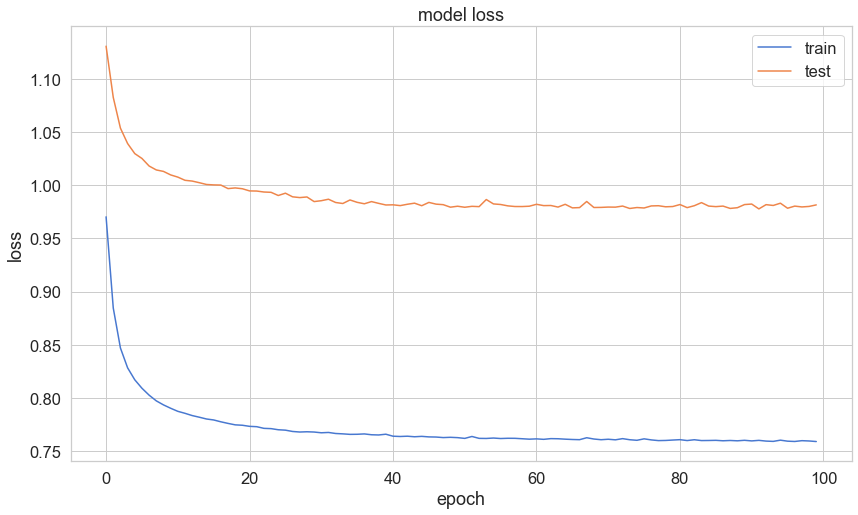

In [48]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let’s have a closer look at the error distribution:

In [49]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({    
    'reconstruction_error': mse,
    'true_class': y_test
})
error_df.describe()

,reconstruction_error,true_class
count,11471.000000,11471.000000
mean,0.969718,0.008892
std,5.093563,0.093881
min,0.040261,0.000000
25%,0.268287,0.000000
50%,0.428432,0.000000
75%,0.673050,0.000000
max,173.322573,1.000000


Because have average reconstruction error as 71% and most of the error are coming from the class as `Fraud`! (<font color='brown'>class label=1</font>)

<a id='sect3_5'></a>
### <font color='darkgreen'>Reconstruction error without fraud</font>
Let's check the error distribution only from class as `Normal`:

Text(0.5, 1.0, 'Error score distribution (Normal)')

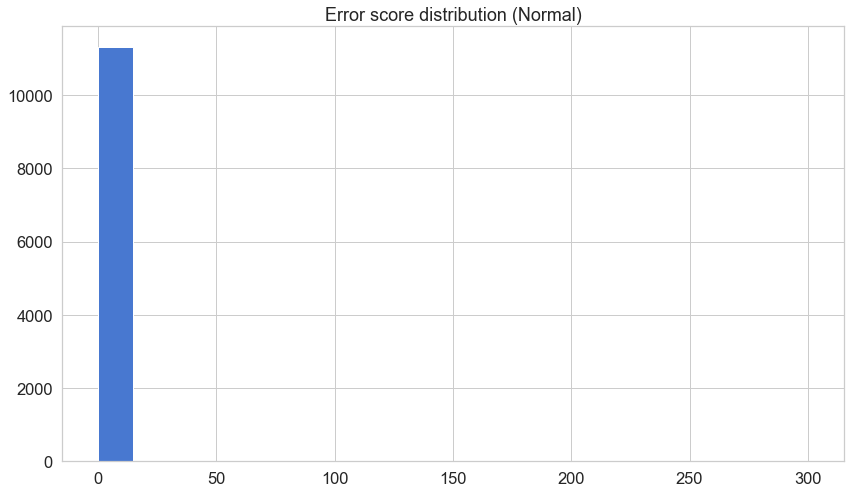

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=20, range=(0, 300))
ax.set_title('Error score distribution (Normal)')

<a id='sect3_6'></a>
### <font color='darkgreen'>Reconstruction error with fraud</font>
Then is the error distribution only from class as `Fraud`:

Text(0.5, 1.0, 'Error score distribution (Fraud)')

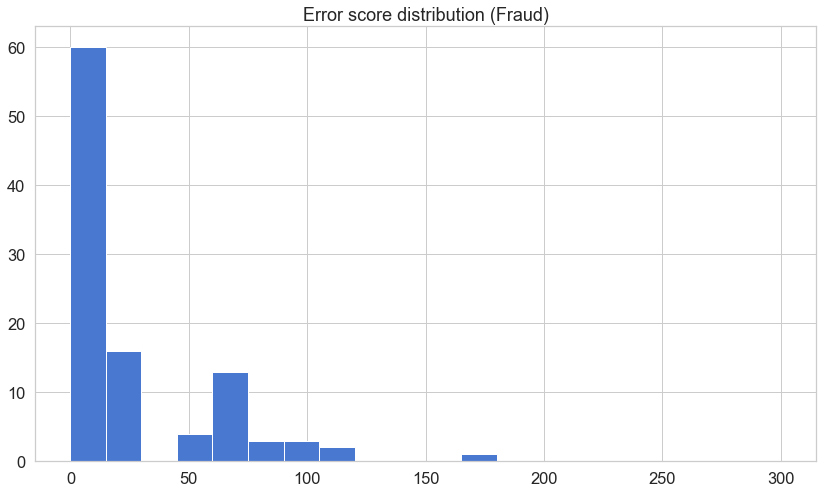

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=20, range=(0, 300))
ax.set_title('Error score distribution (Fraud)')

<b>It is obvious that the class `Fraud` tends to have larger error in general according to comparison from above two histogram charts</b>. [**ROC curves**](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let’s have a look at our ROC curve:

In [53]:
error_df.true_class.head(10)

22600    0
52376    0
5973     0
38620    0
14283    0
7325     0
2822     0
19129    0
24688    0
45899    0
Name: true_class, dtype: int64

In [54]:
error_df.reconstruction_error.head(10)

22600    0.436228
52376    0.132530
5973     0.598819
38620    0.654805
14283    0.135035
7325     0.526916
2822     0.330453
19129    0.781625
24688    0.396358
45899    0.677988
Name: reconstruction_error, dtype: float64

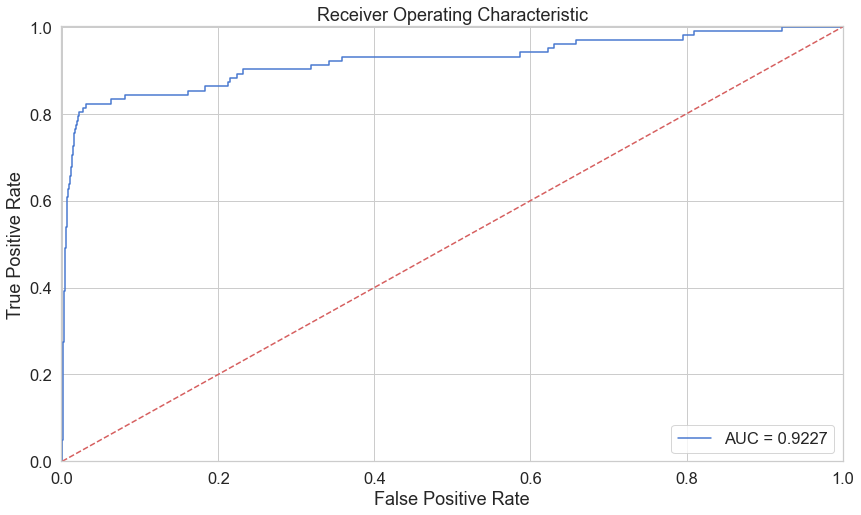

In [55]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

<b>The ROC curve plots the true positive rate versus the false positive rate, over different threshold values.</b> Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn’t look very useful for us. Onward…

<a id='sect3_7'></a>
### <font color='darkgreen'>Precision vs Recall</font>
Precision and recall are defined as follows:
![autoencoder network](images/4.PNG)
![autoencoder network](images/5.PNG)
<br/>
Let’s take an example from Information Retrieval in order to better understand what precision and recall are. Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. Both values can take values between 0 and 1. You would love to have a system with both values being equal to 1.

Let’s return to our example from Information Retrieval. High recall but low precision means many results, most of which has low or no relevancy. When precision is high but recall is low we have the opposite — few returned results with very high relevancy. Ideally, you would want high precision and high recall — many results with that are highly relevant.

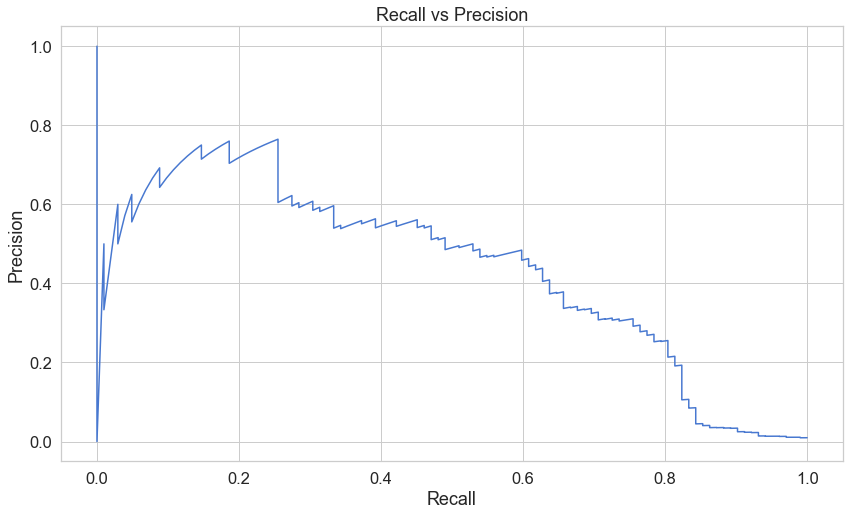

In [56]:
precision, recall, th = metrics.precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

<b>A high area under the curve represents both high recall and high precision</b>, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

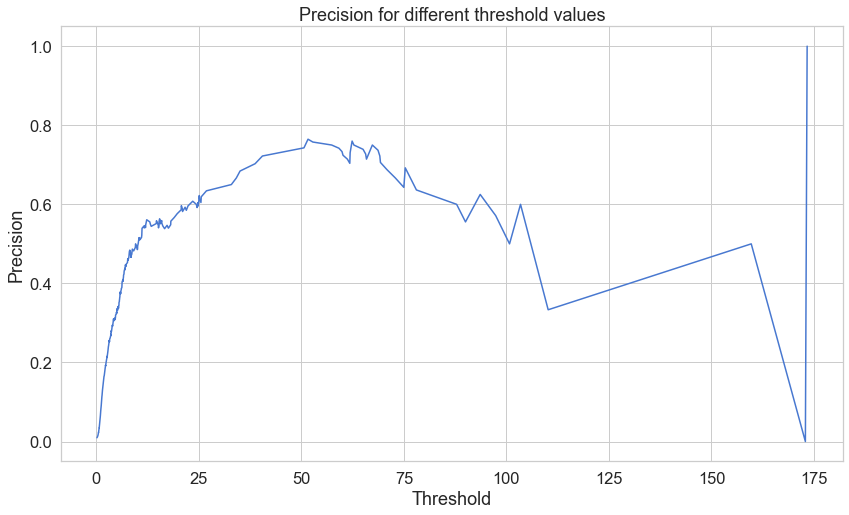

In [57]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let’s have a look at the recall:

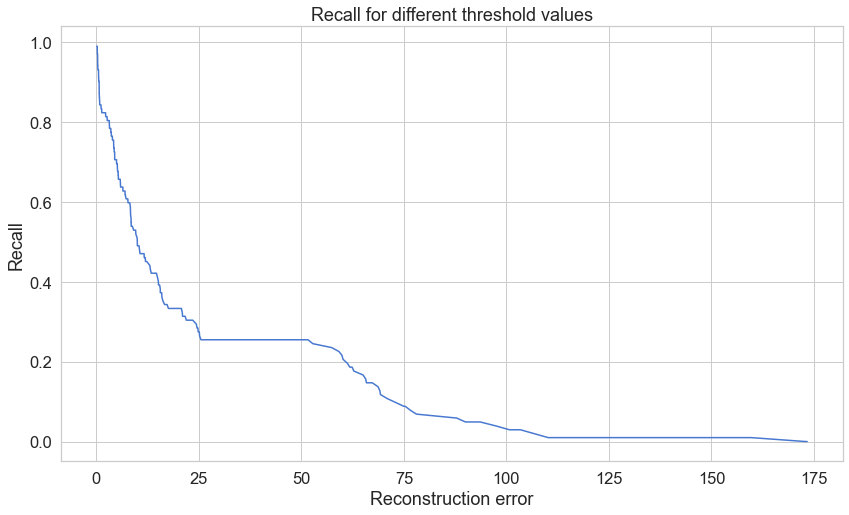

In [58]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

<a id='sect3_8'></a>
### <font color='darkgreen'>Prediction</font>
Our model is a bit different this time. It doesn’t know how to predict new values. But we don’t need that. In order to predict <b>whether or not a new/unseen transaction is normal or fraudulent, we’ll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we’ll mark it as a fraud</b> (<font color='brown'>since our model should have a low error on normal transactions</font>). Let’s pick that value:

In [59]:
RC_ERROR_THRESHOLD = 2.9

And see how well we’re dividing the two types of transactions:

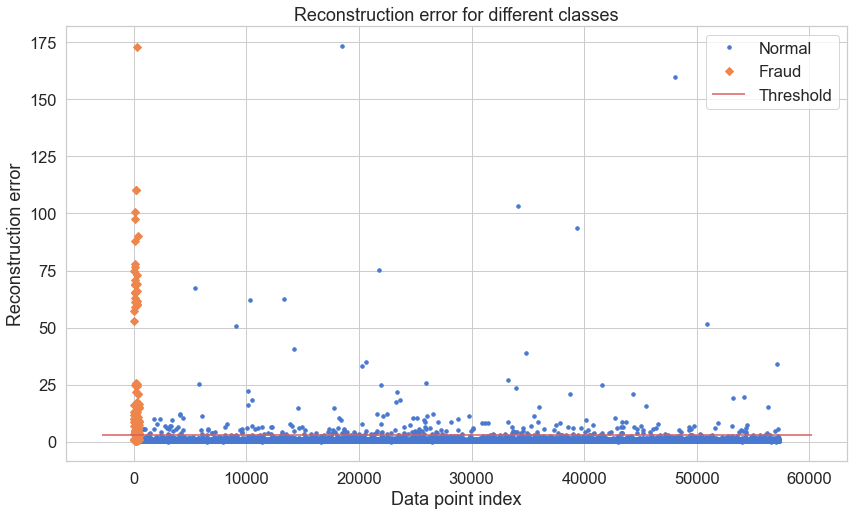

In [60]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

# https://matplotlib.org/3.1.1/api/markers_api.html
for name, group in groups:
    ax.plot(
        group.index, 
        group.reconstruction_error, 
        marker='o' if name == 0 else 'D', 
        ms=3.5 if name == 0 else 5, 
        linestyle='',
        label= "Fraud" if name == 1 else "Normal"
    )
ax.hlines(RC_ERROR_THRESHOLD, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let’s have a look at the confusion matrix:

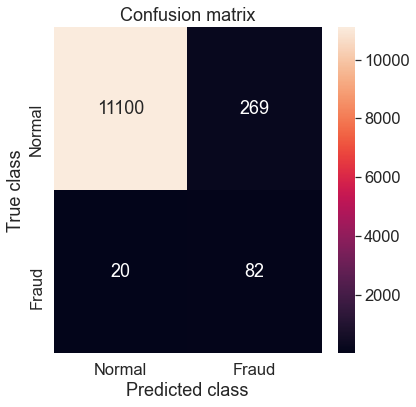

In [61]:
y_pred = [1 if e > RC_ERROR_THRESHOLD else 0 for e in error_df.reconstruction_error.values]
conf_matrix = metrics.confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [87]:
tp, fp, tn, fn = conf_matrix[1][1], conf_matrix[0][1], conf_matrix[0][0], conf_matrix[1][0]
precision = 100 * tp / (tp + fp)
recall = 100 * tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print("Precision={:.01f}%; Recall={:.01f}%; F1={:.01f}%".format(precision, recall, f1))

Precision=23.4%; Recall=80.4%; F1=36.2%


In [88]:
ri = 0
tp_ri_list = []
for yp, tup in zip(y_pred, error_df.iterrows()):
    row = tup[1]
    if yp == 1 and int(row.true_class) == 1:
        tp_ri_list.append(ri)        
    ri += 1
    
print(tp_ri_list)

[93, 111, 393, 513, 720, 811, 1333, 1346, 1386, 1500, 1556, 1820, 2051, 2250, 2327, 2654, 2718, 2891, 3176, 3268, 3312, 3470, 3500, 3502, 3565, 3702, 3808, 4009, 4350, 4534, 4586, 4588, 4750, 5064, 5210, 5217, 5283, 5521, 5588, 5742, 6194, 6266, 6477, 6689, 6785, 6844, 7006, 7029, 7194, 7304, 7757, 7905, 7925, 7965, 7977, 8007, 8289, 8357, 8402, 8424, 8832, 8836, 8992, 9481, 9579, 9696, 9732, 9780, 9782, 9892, 9960, 10130, 10387, 10390, 10493, 10603, 10722, 10925, 10943, 10976, 11074, 11303]


In [89]:
y_test.iloc[tp_ri_list].index

Int64Index([  5, 216, 246, 238, 132, 127, 175, 181,  90,  64, 401,  38, 221,
            165, 299, 460, 248, 442, 477, 259,  29,   0, 360, 489, 109, 420,
            167, 199, 204,   9, 145, 123,  16,  84,  58, 374, 323, 278, 386,
            344, 141, 383, 288, 285, 369,  68,  61, 481, 116, 304, 144,  20,
            268, 230, 370,  57, 294, 265, 390, 307,  27,   8, 227, 124, 463,
             51, 311, 200, 363, 201, 128,  72, 452, 296,  71, 392, 316,  33,
            260, 189, 239, 334],
           dtype='int64')

Our model seems to catch a lot of the fraudulent cases. Of course, there is a catch (see what I did there?). <b><font color='darkred'>The number of normal transactions classified as frauds is really high!</font></b> Is this really a problem? Probably it is. <b>You might want to increase or decrease the value of the threshold, depending on the problem. That one is up to you.</b>

<a id='sect4'></a>
## <font color='darkblue'>Conclusion</font>
We’ve created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Initially, I was a bit skeptical about whether or not this whole thing is gonna work out, bit it kinda did. Think about it, <b>we gave a lot of one-class examples</b> (<font color='brown'>normal transactions</font>) <b>to a model and it learned</b> (<font color='brown'>somewhat</font>) <b>how to discriminate whether or not new examples belong to that same class</b>. Isn’t that cool? Our dataset was kind of magical, though. We really don’t know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. You can search for TensorFlow implementations and see for yourself how much boilerplate you need in order to train one. Can you apply a similar model to a different problem?

<a id='sect5'></a>
## <font color='darkblue'>Supplement</font>
* [Stacked Autoencoders in TensorFlow](https://cmgreen.io/2016/01/04/tensorflow_deep_autoencoder.html)
* [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
* [Stanford tutorial on Autoencoders](http://ufldl.stanford.edu/tutorial/unsupervised/Autoencoders/)
* [Neural networks (6.1) : Autoencoder - definition](https://www.youtube.com/watch?v=FzS3tMl4Nsc&feature=youtu.be)
* [Neural networks (6.2) : Autoencoder - loss function](https://www.youtube.com/watch?v=xTU79Zs4XKY)
* [Intuitions on L1 and L2 Regularisation](https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261)
> The regularisation terms are ‘constraints’ by which an optimisation algorithm must ‘adhere to’ when minimising the loss function, apart from having to minimise the error between the true y and the predicted ŷ.
* [Difference Between a Batch and an Epoch in a Neural Network](https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/)
> The `batch size` is a hyperparameter that defines the number of samples to work through before updating the internal model parameters; The number of `epochs` is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset.